In [1]:
import numpy
import matplotlib.pyplot as plt
import matplotlib.gridspec as gspec
import msprime
import pickle
import tqdm
import pathlib2
import bz2

metaRNG = numpy.random.default_rng (4711)

In [2]:
# load simulations from pickled files, if they are available
LOAD_FROM_PICKLE = True

#### functions to proces simulated data and compute statistics

In [3]:
# convert to genotype matrix
def mtsToGeno (mts):

    # empty containers
    genoMatrix = -1 * numpy.ones ((mts.num_sites, mts.num_samples), dtype=int)
    positions = -1 * numpy.ones (mts.num_sites, dtype=int)
    numAlleles = -1 * numpy.ones (mts.num_sites, dtype=int)

    # iterate through variants
    currIdx = 0
    for var in mts.variants():

        # save all stuff
        positions[currIdx] = var.position
        numAlleles[currIdx] = len(var.alleles)
        genoMatrix[currIdx,:] = var.genotypes

        # increase index
        currIdx += 1

    # some checks
    assert (genoMatrix.min() >= 0)
    assert (positions.min() >= 0)
    # no duplicate positions
    assert (numpy.all (numpy.diff (positions) > 0))
    assert (numAlleles.min() >= 0)

    return (positions, numAlleles, genoMatrix)

In [4]:
def removeNonBiallelic (positions, numAlleles, genoMatrix):
    # get rid of all sites that are not biallelic
    biallelicMask = (numAlleles == 2)
    positions = positions[biallelicMask]
    numAlleles = numAlleles[biallelicMask]
    genoMatrix = genoMatrix[biallelicMask,:]
    assert (numpy.all (numAlleles == 2))
    assert (numpy.all (numpy.isin (genoMatrix.flatten(), [0,1])))

    return (positions, numAlleles, genoMatrix)

In [5]:
def removeNonSegregating (positions, numAlleles, genoMatrix):
    # get rid of non-segregating, cause they mess up LD
    numDer = numpy.sum (genoMatrix, axis=1)
    segregatingMask = (0 < numDer) & (numDer < genoMatrix.shape[1])
    positions = positions[segregatingMask]
    numAlleles = numAlleles[segregatingMask]
    genoMatrix = genoMatrix[segregatingMask,:]
    assert (numpy.all (numpy.sum (genoMatrix, axis=1) > 0))
    assert (numpy.all (numpy.sum (genoMatrix, axis=1) < genoMatrix.shape[1]))

    return (positions, numAlleles, genoMatrix)

In [6]:
def getFreqs (focalGeno, windowGeno):

    # get hap freq
    hapCount = windowGeno * focalGeno
    hapFreq = numpy.sum(hapCount, axis =1) / hapCount.shape[1]

    # get marginal freqs
    windowFreq = numpy.sum(windowGeno, axis =1) / windowGeno.shape[1]
    assert (numpy.all (0 < windowFreq))
    assert (numpy.all (windowFreq < 1))
    assert (len(focalGeno.shape) == 1)
    focalFreq = numpy.sum (focalGeno) / focalGeno.shape[0]
    assert ((0 < focalFreq) & (focalFreq < 1))

    return (hapFreq, focalFreq, windowFreq)

In [7]:
# assumes that 0 is ancestral and 1 is derived
def computeLD (focalGeno, windowGeno):

    # get freqs
    (hapFreq, focalFreq, windowFreq) = getFreqs (focalGeno, windowGeno)

    # compute LD values
    D = hapFreq - windowFreq * focalFreq
    rSquared = D*D / (windowFreq*(1-windowFreq)*focalFreq*(1-focalFreq))

    return rSquared

In [8]:
# assumes that 0 is ancestral and 1 is derived
def computeCrossLD (focalGenoOne, windowGenoOne, focalGenoTwo, windowGenoTwo):

    # get freqs
    (hapFreqOne, focalFreqOne, windowFreqOne) = getFreqs (focalGenoOne, windowGenoOne)
    (hapFreqTwo, focalFreqTwo, windowFreqTwo) = getFreqs (focalGenoTwo, windowGenoTwo)

    # compute LD values
    dOne = hapFreqOne - windowFreqOne * focalFreqOne
    dTwo = hapFreqTwo - windowFreqTwo * focalFreqTwo

    # diversity
    piOne = windowFreqOne*(1-windowFreqOne)*focalFreqOne*(1-focalFreqOne)
    piTwo = windowFreqTwo*(1-windowFreqTwo)*focalFreqTwo*(1-focalFreqTwo)

    # finally the cross LD
    rSquared = dOne*dTwo / (numpy.sqrt(piOne) * numpy.sqrt(piTwo))

    return rSquared

### single panmictic population

In [9]:
# popgen parameters
panRecoRate = 1.25e-8
panMutRate = 1.25e-8
panSequenceLength = 100e6
panDiploidSampleSize = 100

panmicticScenarios = {
    'Constant': ([], [1e4]),
    'Bottleneck': ([1.5e4, 2.5e4], [1e4, 2.5e3, 1e4])
}

panmicticDemographies = {}
for (k, v) in panmicticScenarios.items():
    # unpack v
    (thisTimes, thisSizes) = v
    assert (len(thisTimes)+1 == len(thisSizes))

    thisDemo = msprime.Demography()
    # every population has a size
    thisDemo.add_population (initial_size=thisSizes[0])

    # and add some changes if there are any
    for sIdx in numpy.arange(len(thisTimes)):
        thisDemo.add_population_parameters_change (time=thisTimes[sIdx], initial_size=thisSizes[sIdx+1], population=0)

    # and store the demo
    panmicticDemographies[k] = thisDemo

In [10]:
%%time

popSizeMtsPickleFile = 'popsize_mts.pickle.bz2'

if (pathlib2.Path(popSizeMtsPickleFile).is_file() and LOAD_FROM_PICKLE):
    print (f"File {popSizeMtsPickleFile} exists, load data.")
    # load pickle
    treeSequencesPanmictic = pickle.load (bz2.open (popSizeMtsPickleFile, 'rb'))
else:
    print (f"File {popSizeMtsPickleFile} does not exist or shouldn't be loaded, generate data.")
    treeSequencesPanmictic = {}

    for (demoLabel, thisDemo) in panmicticDemographies.items():

        # first the tree sequence
        ts = msprime.sim_ancestry (samples=panDiploidSampleSize, recombination_rate=panRecoRate, sequence_length=panSequenceLength,
                                    demography=thisDemo, random_seed=metaRNG.integers (99999999))

        # then mutations on the trees
        mts = msprime.sim_mutations (ts, rate=panMutRate, random_seed=metaRNG.integers (99999999))

        # store it
        treeSequencesPanmictic[demoLabel] = mts

    # and pickle it
    pickle.dump (treeSequencesPanmictic, bz2.open (popSizeMtsPickleFile, 'wb'))

File popsize_mts.pickle.bz2 exists, load data.
CPU times: user 3.95 s, sys: 207 ms, total: 4.16 s
Wall time: 4.3 s


In [11]:
# # set up LD hist
# minDist = 0.1
# maxDist = 1e5
# distBins = 20
# bounds = numpy.linspace (minDist, maxDist, distBins)
# lowerB = bounds[:-1]
# upperB = bounds[1:]

In [12]:
# # go through all and compute LD

# popSizeLdPickleFile = 'popsize_ld.pickle.bz2'

# if (pathlib2.Path(popSizeLdPickleFile).is_file() and LOAD_FROM_PICKLE):
#     print (f"File {popSizeLdPickleFile} exists, load data.")
#     # load pickle
#     ldHistsPanmictic = pickle.load (bz2.open (popSizeLdPickleFile, 'rb'))
# else:
#     print (f"File {popSizeLdPickleFile} does not exist or shouldn't be loaded, generate data.")
#     windowSize = maxDist
#     ldHistsPanmictic = {}

#     for (demoLabel, mts) in treeSequencesPanmictic.items():

#         print (demoLabel)
        
#         # convert to proper geno matrix
#         (positions, numAlleles, genoMatrix) = mtsToGeno (mts)
#         (positions, numAlleles, genoMatrix) = removeNonBiallelic (positions, numAlleles, genoMatrix)
#         (positions, numAlleles, genoMatrix) = removeNonSegregating (positions, numAlleles, genoMatrix)

#         # (re)set histogram
#         avgValues = numpy.zeros (lowerB.shape[0])
#         numInBin = numpy.zeros (lowerB.shape[0])

#         for idx in tqdm.tqdm (numpy.arange (genoMatrix.shape[0])):

#             # focal stuff 
#             focalPos = positions[idx]
#             focalGeno = genoMatrix[idx,:]

#             # window stuff
#             windowMask = (positions >= focalPos - windowSize) & (positions < focalPos + windowSize)
#             windowGeno = genoMatrix[windowMask,:]
#             windowPos = positions[windowMask]

#             # get the dist from focal
#             windowDists = numpy.abs (focalPos - windowPos)

#             # get the LD
#             lds = computeLD (focalGeno, windowGeno)

#             # save them in the histogram
#             for binIdx in numpy.arange (lowerB.shape[0]):
#                 # get the mask for this bin
#                 binMask = (lowerB[binIdx] < windowDists) & (windowDists < upperB[binIdx])

#                 # and add it to hist
#                 avgValues[binIdx] += numpy.sum (lds[binMask])
#                 # how many added
#                 numInBin[binIdx] += numpy.sum (binMask)

#         # remember the histogram
#         ldHistsPanmictic[demoLabel] = avgValues / numInBin

#     # and pickle it
#     pickle.dump (ldHistsPanmictic, bz2.open (popSizeLdPickleFile, 'wb'))


In [13]:
# # check neutral SFS
# numDer = numpy.sum (genoMatrix, axis=1)
# (histY, histX) = numpy.histogram (numDer, range=(0.5,genoMatrix.shape[1]-0.5), bins=genoMatrix.shape[1]-1)
# xs = (histX[:-1] + histX[1:])/2
# plt.plot (xs, histY)
# plt.xscale ("log")
# plt.yscale ("log")

### two population divergence

In [14]:
# popgen parameters
divRecoRate = 1.25e-8
divMutRate = 1.25e-8
divSequenceLength = 100e6
divDiploidSampleSizes = [20, 20]
divAncestralSize = 1e4
divExtantSizes = [5e3, 5e3]
divergenceTime = 5e3

divMigrationRates = {
    "Clean Split" : 0,
    "IM (low)": 5e-5,
    "IM (high)": 1e-3,
}

divergenceDemographies = {}
for (k,v) in divMigrationRates.items():

    # create a demography with two populations that diverge
    thisDemo = msprime.Demography()
    thisDemo.add_population (name="ancestral", initial_size=divAncestralSize)
    thisDemo.add_population (name="extantOne", initial_size=divExtantSizes[0])
    thisDemo.add_population (name="extantTwo", initial_size=divExtantSizes[1])
    thisDemo.add_population_split (time=divergenceTime, derived=["extantOne", "extantTwo"], ancestral="ancestral")

    # add migratiom rates more recent than divergence
    thisDemo.set_symmetric_migration_rate (populations=["extantOne","extantTwo"], rate=v)

    # save it
    divergenceDemographies[k] = thisDemo

In [15]:

divMtsPickleFile = 'divergence_mts.pickle.bz2'

if (pathlib2.Path(divMtsPickleFile).is_file() and LOAD_FROM_PICKLE):
    print (f"File {divMtsPickleFile} exists, load data.")
    # load pickle
    treeSequencesDiv = pickle.load (bz2.open (divMtsPickleFile, 'rb'))
else:
    print (f"File {divMtsPickleFile} does not exist or shouldn't be loaded, generate data.")

    treeSequencesDiv = {}

    for (thisLabel, thisDemo) in divergenceDemographies.items():

        # first simulate tree sequence
        ts = msprime.sim_ancestry (samples={"extantOne": divDiploidSampleSizes[0], "extantTwo": divDiploidSampleSizes[1]},
                                        recombination_rate=divRecoRate, sequence_length=divSequenceLength, demography=thisDemo,
                                        random_seed=metaRNG.integers (99999999))

        # then mutations on the trees
        mts = msprime.sim_mutations(ts, rate=divMutRate, random_seed=metaRNG.integers (99999999))

        # store it
        treeSequencesDiv[thisLabel] = mts
    
    # and pickle it
    pickle.dump (treeSequencesDiv, bz2.open (divMtsPickleFile, 'wb'))

File divergence_mts.pickle.bz2 exists, load data.


In [16]:
# set up LD hist
minDist = 0.1
maxDist = 1e5
distBins = 20
bounds = numpy.linspace (minDist, maxDist, distBins)
lowerB = bounds[:-1]
upperB = bounds[1:]

In [17]:
# compute statistics

divStatPickleFile = 'divergence_stat.pickle.bz2'

if (pathlib2.Path(divStatPickleFile).is_file() and LOAD_FROM_PICKLE):
    print (f"File {divStatPickleFile} exists, load data.")
    # load pickle
    (jointSFS, ldHistsDiv) = pickle.load (bz2.open (divStatPickleFile, 'rb'))
else:
    print (f"File {divStatPickleFile} does not exist or shouldn't be loaded, generate data.")
    # go through all loci

    jointSFS = {}

    windowSize = maxDist

    ldHistsDiv = {}

    for (thisLabel, mts) in treeSequencesDiv.items():

        print (thisLabel)

        # +1, cause we want fixed in one population
        thisJointSFS = numpy.zeros ((2*divDiploidSampleSizes[0]+1, 2*divDiploidSampleSizes[1]+1))

        # convert to proper geno matrix
        (positions, numAlleles, genoMatrix) = mtsToGeno (mts)
        (positions, numAlleles, genoMatrix) = removeNonBiallelic (positions, numAlleles, genoMatrix)
        (positions, numAlleles, genoMatrix) = removeNonSegregating (positions, numAlleles, genoMatrix)

        # then split into both populations
        genoMatrixOne = genoMatrix[:,:2*divDiploidSampleSizes[0]]
        genoMatrixTwo = genoMatrix[:,2*divDiploidSampleSizes[0]:]

        # get the derived alleles
        numDerOne = numpy.sum (genoMatrixOne, axis=1, dtype=int)
        numDerTwo = numpy.sum (genoMatrixTwo, axis=1, dtype=int)

        # go thourgh once for the SFS
        for idx in tqdm.tqdm (numpy.arange (genoMatrix.shape[0])):

            # remember the entry in the joint SFS
            thisJointSFS[numDerOne[idx], numDerTwo[idx]] += 1

        # remember this joint SFS
        jointSFS[thisLabel] = thisJointSFS

        # # go through again for LD, but remove the ones that don't segregate across the population first
        # keepMask = (numDerOne > 0) & (numDerOne < genoMatrixOne.shape[1]) & (numDerTwo > 0) & (numDerTwo < genoMatrixTwo.shape[1])

        # positions = positions[keepMask]
        # genoMatrixOne = genoMatrixOne[keepMask]
        # genoMatrixTwo = genoMatrixTwo[keepMask]

        # NEW AND IMPROVED
        # ld with just the full genotype matrix across the populations

        # (re)set histogram
        avgValues = numpy.zeros (lowerB.shape[0])
        numInBin = numpy.zeros (lowerB.shape[0])

        # now go through it
        for idx in tqdm.tqdm (numpy.arange (genoMatrixOne.shape[0])):

            # focal stuff 
            focalPos = positions[idx]
            # focalGenoOne = genoMatrixOne[idx,:]
            # focalGenoTwo = genoMatrixTwo[idx,:]
            focalGeno = genoMatrix[idx,:]

            # window stuff
            windowMask = (positions >= focalPos - windowSize) & (positions < focalPos + windowSize)
            windowPos = positions[windowMask]
            windowDists = numpy.abs (focalPos - windowPos)

            # windowGenoOne = genoMatrixOne[windowMask,:]
            # windowGenoTwo = genoMatrixTwo[windowMask,:]
            windowGeno = genoMatrix[windowMask,:]

            # get the LD
            # lds = computeCrossLD (focalGenoOne, windowGenoOne, focalGenoTwo, windowGenoTwo)
            lds = computeLD (focalGeno, windowGeno)

            # save them in the histogram
            for binIdx in numpy.arange (lowerB.shape[0]):
                # get the mask for this bin
                binMask = (lowerB[binIdx] < windowDists) & (windowDists < upperB[binIdx])

                # and add it to hist
                avgValues[binIdx] += numpy.sum (lds[binMask])
                # how many added
                numInBin[binIdx] += numpy.sum (binMask)


        # remember the histogram
        ldHistsDiv[thisLabel] = avgValues / numInBin
    
    # and pickle it
    pickle.dump ((jointSFS, ldHistsDiv), bz2.open (divStatPickleFile, 'wb'))


File divergence_stat.pickle.bz2 exists, load data.


#### coalescent rates

In [18]:
# combine all simulations to reuse code
allTreeSequences = {}
for (k,v) in treeSequencesPanmictic.items():
    allTreeSequences[k] = v
for (k,v) in treeSequencesDiv.items():
    allTreeSequences[k] = v

In [19]:
# do we want to skip trees?
skipTrees = True
skipInterval = 1e4

coalescenceTimes = {}
spans = {}

for (k, v) in allTreeSequences.items():

    print (k)

    # make new containers
    coalescenceTimes[k] = []
    spans[k] = []

    # try making this work for oanmictic and divergence
    firstSampleId = 0
    lastSampleId = v.num_samples-1

    currIdx = 0
    # if we start like this, the first tree will be recorded
    lastIdx = -2
    
    # go through trees and see where they fall
    for localTree in tqdm.tqdm(v.trees()):

        thisTime = localTree.tmrca (firstSampleId, lastSampleId)
        thisSpan = localTree.span

        # this is the time
        if (skipTrees):
            # currIdx is starting index of current tree
            if (currIdx > lastIdx + 1):
                nextIdx = numpy.floor (currIdx)
                # we want this tree
                coalescenceTimes[k].append (thisTime)
                # but all weighed by how many indicees they span
                spans[k].append (nextIdx - lastIdx)
                lastIdx = nextIdx
            # need to increment this anyways
            currIdx = currIdx + thisSpan/skipInterval
        else:
            coalescenceTimes[k].append (thisTime)
            # no skipping, so it has a weight
            spans[k].append (thisSpan)
        
    # just making sure we counted trees correctly
    assert (panSequenceLength == divSequenceLength)
    if (skipTrees):
        assert (numpy.isclose ((numpy.sum(spans[k])-1) * skipInterval, panSequenceLength))
    else:
        assert (numpy.isclose (numpy.sum(spans[k]), panSequenceLength))


Constant


100%|██████████| 262930/262930 [00:01<00:00, 228830.55it/s]


Bottleneck


100%|██████████| 226185/226185 [00:00<00:00, 233062.23it/s]


Clean Split


100%|██████████| 214805/214805 [00:00<00:00, 238703.25it/s]


IM (low)


100%|██████████| 215961/215961 [00:00<00:00, 242933.46it/s]


IM (high)


100%|██████████| 213565/213565 [00:00<00:00, 240396.88it/s]


### make some plots

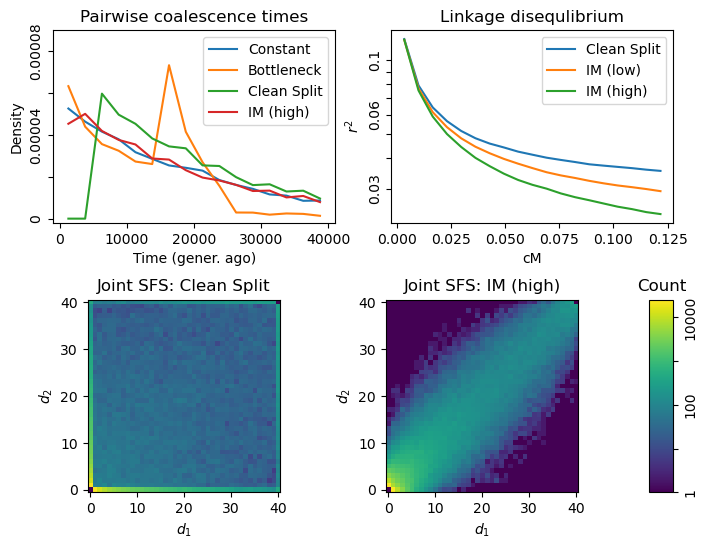

In [20]:
fig = plt.figure(figsize=(8, 6))
# matplotlib is strange
gsTwo = gspec.GridSpec (2, 2)
gsThree = gspec.GridSpec (2, 3, width_ratios=[11,11,1])
ax1 = plt.subplot (gsTwo[0,0])
ax2 = plt.subplot (gsTwo[0,1])
ax3 = plt.subplot (gsThree[1,0])
ax4 = plt.subplot (gsThree[1,1])
ax5 = plt.subplot (gsThree[1,2])

# first plot: coalescent rates
minTime = 0
maxTime = 4e4
timeBins = 16
thisAx = ax1
theLegend = []
for k in coalescenceTimes.keys():
    if ('low' in k):
        continue
    (histY, histX) = numpy.histogram (coalescenceTimes[k], weights=spans[k], range=(minTime, maxTime), bins=timeBins, density=True)
    plotX = histX[:-1]/2 + histX[1:]/2
    thisAx.plot (plotX, histY)
    theLegend.append (k)
thisAx.legend (theLegend)
thisAx.set_title ("Pairwise coalescence times")
thisAx.set_xlabel ("Time (gener. ago)")
thisAx.set_ylabel ("Density")
thisAx.set_yticks ([0, 0.00002, 0.00004, 0.00006, 0.00008])
thisAx.set_yticklabels (["0", "", "0.00004", "", "0.00008"], rotation=90, va='center')
thisAx.set_xlim (-1000, 41000)
thisAx.set_ylim (-2e-6, 0.00009)

# second plot: divergence LD
thisAx = ax2
theLegend = []
xs = (lowerB + upperB)/2 * (divRecoRate/0.01)
for (tDiv, thisHist) in ldHistsDiv.items():
    thisAx.plot (xs, thisHist)
    theLegend.append (tDiv)
thisAx.legend (theLegend)
# thisAx.set_xscale ('log')
thisAx.set_yscale ('log')
thisAx.set_title ("Linkage disequlibrium")
thisAx.set_xlabel ("cM")
thisAx.set_ylabel (r"$r^2$")
thisAx.set_yticks ([0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1])
thisAx.set_yticklabels (["0.03", "", "", "0.06", "", "", "", "0.1"], rotation=90, va='center')

# get the min and max
demoLabelOne = 'Clean Split'

# third plot: joint SFS, recent divergence
thisAx = ax3
demoLabel = 'Clean Split'
# add pseudo-counts
plotSFS = jointSFS[demoLabel] + 1
thisAx.imshow (numpy.log10(plotSFS), origin='lower')
thisAx.set_xlabel (r"$d_1$")
thisAx.set_ylabel (r"$d_2$")
theTicks = [0,10,20,30,40]
thisAx.set_yticks (theTicks)
thisAx.set_yticklabels (theTicks)
thisAx.set_xticks (theTicks)
thisAx.set_xticklabels (theTicks)
thisAx.set_title (f"Joint SFS: {demoLabel}" )

# fourth plot: joint SFS, ancient divergence
thisAx = ax4
demoLabel = 'IM (high)'
# add pseudo-counts
plotSFS = jointSFS[demoLabel] + 1
theIM = thisAx.imshow (numpy.log10(plotSFS), origin='lower')
thisAx.set_xlabel (r"$d_1$")
thisAx.set_ylabel (r"$d_2$")
theTicks = [0,10,20,30,40]
thisAx.set_yticks (theTicks)
thisAx.set_yticklabels (theTicks)
thisAx.set_xticks (theTicks)
thisAx.set_xticklabels (theTicks)
thisAx.set_title (f"Joint SFS: {demoLabel}" )

# colobar?
thisAx = ax5
fig.colorbar (theIM, cax=thisAx)
thisAx.set_yticks ([0, 1, 2, 3, 4])
thisAx.set_yticklabels (["1", "", "100", "", "10000"], rotation=90, va='center')
thisAx.set_title ("Count")

# plt.tight_layout()
# plt.subplots_adjust (top = 0.99, bottom=0.01, hspace=1.5, wspace=0.4)
plt.subplots_adjust (hspace=.4)
plt.savefig("figure_2_demo_stats.pdf")
plt.show()
